# Practical session 01 - caffe

This notebook is for use in the Max-Planck ETH Center for Learning Systems workshop on Deep Learning (July 11th-13th 2016, Donaueschingen) only. Author: Christoph Lassner.

**All IPython notebooks are stored read-only. You can create your own, writeable copy by using "File" -> "Make a copy...".**

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib notebook

## Part 1 - Finding your way around caffe

This first part of the session will show you your way around the caffe source, before the API concepts will be introduced. Since there exist so many forks of caffe, this knowledge is vital to quickly find the areas of change, and being able to integrate them in your own copy of caffe.

To browse the source of your caffe installation in the virtual machine, cd to `~/barrista/caffe`.

The project follows a classical C++ project setup:

* The root folder contains a `Makefile` (not recommended and less well maintained) and the `CMakeLists.txt` build specification,
* The `build` subfolder has been created to build this setup. It contains a `cmake_call.sh` file to store the build parameters. The one created here is very unspectacular and just specifies `CPU_ONLY` mode.
* The headers are located in `include/caffe`,
* The source files in `src/caffe`.
* IMPORTANT: caffe is a project constantly changing and reorganizing and not always in a perfect cleaned-up state, e.g., the solvers have a common header `sgd_solvers.hpp` but several implementation files.
* The **protobuf** specification is in `src/caffe/proto/caffe.proto`,
* The **Python** interface is in the folder `python`,
* The **tests** are in the folder `src/caffe/test`.

## Exercise 1

Find your way around the caffe source code and adjust the caffe build to your needs.

* Create a new caffe build without Python support in a new folder `build_wo_python`,
* Locate all code that is concerned with the implementation of the convolutional layer (*Hint: there are 4+1+3+1 files involved!*).

------------------------------------

## Part 2 - The core caffe concepts

* **blob**: This object is at the heart of caffe models. It is an abstraction of 'weight' factors. These weights are copied on-demand to or from GPU to or from CPU. For every weight, a diff is stored as well, but does not have to be valid at all times (e.g., only after backprop). Every `net` object has many `blob` objects, which represent data before or after a processing step. The parameters are stored in a property named `params`, which contains `blob` objects as well (note the ambiguity of nomenclature!).

* **Layer**: receives blobs as inputs and produces new blobs. Both numbers can be set to vary. Can have `param` blobs.

* **Net**: A DAG of layers.

* **Solver**: Uses gradients to update weights.

<IPython.core.display.Javascript object>


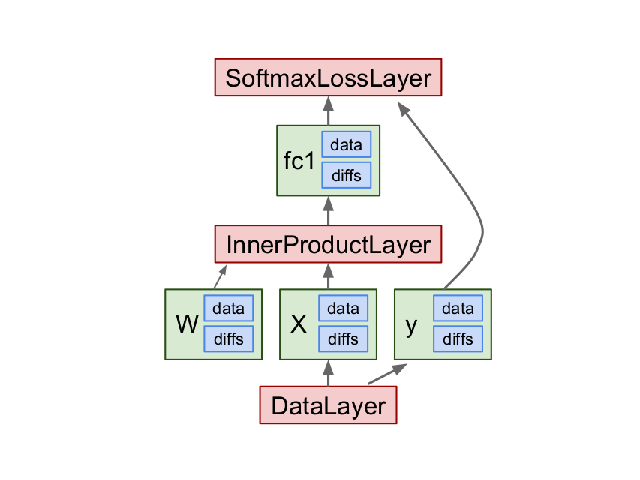

In [2]:
CONC_VIS = cv2.imread('support-material/concept-visualization.png')[:, :, ::-1]
plt.figure(); plt.imshow(CONC_VIS); plt.axis('off'); plt.show()
# c.t. http://cs231n.stanford.edu/slides/winter1516_lecture12.pdf

## Protobuf

The protobuf specification defines a language to communicate with. This is being done in the file `src/caffe/proto/caffe.proto`. The 'language' specification must contain the definition for all possible 'words' that can be used (e.g., layers), so if you add a new layer or other object, the definition must be adjusted accordingly.

A basic example from google's documentation:

.proto file:

    message Person {
        required string name = 1;
        required int32 id = 2;
        optional repeated string email = 3;
    }

.prototxt file:

    name: "John Doe"
    id: 1234
    email: "jdoe@example.com"
    email: "sunflower1234@doe.com"

**It is vital to understand how these concepts interact, because you will have to update the definitions for every change/additions to layer types!**

### Specifying the logistic regression net

The example shown before for the logistic regression model can be implemented in caffe .prototxt as follows:

    name: "LogisticRegressionNet"
    layers {
      top: "data"
      top: "label"
      name: "data"
      type: DATA
      include {
          phase: TRAIN
      }
      data_param {
        source: "/home/barrista/notebooks/support-material/MNIST/train_lmdb"
        batch_size: 64
        backend: LMDB
      }
    }
    layers {
      top: "data"
      top: "label"
      name: "data"
      type: DATA
      include {
          phase: TEST
      }
      data_param {
        source: "/home/barrista/notebooks/support-material/MNIST/test_lmdb"
        batch_size: 100
        backend: LMDB
      }
    }
    layers {
      bottom: "data"
      top: "fc1"
      name: "fc1"
      type: INNER_PRODUCT
      inner_product_param {
        num_output: 10
      }
    }
    layers {
      bottom: "fc1"
      bottom: "label"
      top: "loss"
      name: "loss"
      type: SOFTMAX_LOSS
    }

The `bottom` and `top` fields provide the connections, the `layers` the nodes in the DAG. We will have a look at the DATA layer in the following sections.

**CRITICAL:** You MUST specify two DIFFERENT databases for training and testing (the error message is cryptic and will not hint at this fact)!

**CRITICAL:** You MUST use the correct number of outputs for the last layer leading to the softmax loss. Again, the error messages will otherwise be cryptic and not hint at this flaw whatsoever!

## Exercise 2

* The logistic regression will converge a lot better if the weights are initialized randomly gaussian instead of constant zero (the default). The required parameter to modify this behaviour is the `weight_filler` parameter for the `inner_product_param`. Find out how this can be specified and create a full `.prototxt` specification at a location of your choice.

* Create a second configuration (predict configuration) of the network that does not use a SOFTMAX_LOSS layer in the end, but outputs the plain fc1 values. The 'label' top of the data layer is now not needed any more. This is a standard procedure to make networks ready for deployment. You can test your configuration after training (see next part) with the command `~/barrista/caffe/build/install/bin/caffe test -model /path/to/model.prototxt -weights /path/to/weights.caffemodel`.

--------------------------------------------

## Part 3 - Data layers & solvers

Data can be provided from several sources:

* LMDB databases,
* LevelDB databases,
* HDF5 databases,
* Images names stored in a textfile,
* Directly from memory (within Python).

For this example, we will convert the MNIST data to an LMDB database. Since MNIST is a frequently used standard dataset, caffe provides a script to do so. I converted the data already for you to the database `/home/barrista/notebooks/support-material/MNIST/train_lmdb`.

## Solvers

Solvers encapsulate the optimization process. An example solver specification for the logistic regression network could be

    net: "01-lrnet.prototxt"
    test_iter: 100
    test_interval: 500
    base_lr: 0.001
    lr_policy: "step"
    gamma: 0.1
    stepsize: 10000
    display: 20
    max_iter: 10000
    momentum: 0.9
    weight_decay: 0.0005
    snapshot: 5000
    snapshot_prefix: "lrnet"
    solver_mode: CPU

### Exercise 3: Training

Use the model, solver and data to make a fit using caffe. You can use the following command line for this:

`~/barrista/caffe/build/install/bin/caffe train -solver /path/to/solver.prototxt`

# You just trained your first caffe model!

--------------------------------------------------------------

## Part 4 - Finetuning a model

Often, you can start out from a pre-trained model, alter it and finetune it to your data. In many cases, all of this can be achieved solely by modifying the .prototxt files (with the notable exception of explicit weight changes for certain layer types).

Caffe uses the following dangerous policy for loading a prototxt model and associated weights:

* The model is instantiated solely by its description,
* For any EXISTING layer, the weights are copied from the storage-file.

**BE CAREFUL NOT TO SCREW UP YOUR MODELS BY CHANGING LAYER NAMES**.

However, this allows to add or drop layers on purpose and use proper weight initialization (as in Exercise 2).

## Exercise 4

Add a new fully-connected layer to your model. Train it by using the weights from your previously trained model as initialization (add the `-weights` parameter to the command line call, and be sure to get the prefixing right).

-------------------------------

## Part 5 - Bonus: adding new layers

To define a new layer, several places must be touched:

* The **protobuf specification** must be adjusted. A new layer must be added, optionally with new parameters,
* A **header** and **source** file must be created.
* The layer must be **instantiated** by using the macro `INSTANTIATE_CLASS`,
* The layer must be **registered** in the layer registry by using the macro `REGISTER_LAYER_CLASS`,
* The layer must be **tested** by creating a new test in `src/caffe/test`.

### Exercise 5

Copy the INNER_PRODUCT layer and go through all the mentioned steps (come up with a new name to avoid name-clashes). Create and run the tests by running `cmake --build . --target runtest`. Train a logistic regression net with the new layer.

------------------------------------

## Outlook to Session 2 - Testing models and visualization

Caffe does not come with tools for visualizing results or the training progress. But don't miss out all this fun in the next tutorial session for **`barrista`**!

To give you a good taste of what this is headed for, all the things done before, including data pre-processing, can be done with the following few lines of Python (and on top of it, much more!):

In [3]:
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import barrista.design as ds
import barrista.solver as sv
import barrista.monitoring as mnt

mnist = fetch_mldata('MNIST original',
                     data_home='/home/barrista/notebooks/support-material/mldata')
tr_data, te_data, tr_labels, te_labels = train_test_split(
    mnist.data.reshape((70000, 1, 28, 28)).astype('float32'),
    mnist.target.reshape((70000, 1)).astype('float32'),
    train_size=60000)

netspec = ds.NetSpecification([[100, 1, 28, 28], [100]],
                              inputs=['data', 'labels'])
netspec.phase = ds.PROTODETAIL.TRAIN
netspec.layers.append(
    ds.InnerProductLayer(
        name='fc1',
        InnerProduct_num_output=10))
netspec.layers.append(
    ds.SoftmaxWithLossLayer(
        name='loss',
        bottoms=['fc1', 'labels']))
net = netspec.instantiate()
net.fit(10000,
        sv.SGDSolver(base_lr=1e-5, momentum=0.9),
        X={'data': tr_data, 'labels': tr_labels},
        X_val={'data': te_data, 'labels': te_labels},
        test_interval=500,
        train_callbacks=[mnt.ProgressIndicator()])

ls: 0.4549|: 100%|██████████| 10000/10000 [00:10<00:00, 990.26it/s]
